In [1]:
####This script helps to explore spleen single cell rna seq data available from the
######murine aging cell atlas (https://mca.research.calicolabs.com/data)


In [2]:
####Import modules

import os
import anndata
import pandas
import numpy
import scanpy
import csv
import re
import matplotlib.pyplot as plt


In [3]:
####Set working directory

os.chdir('/mnt/d/sc_rna_data_project_20201113') 


In [4]:
####Importing and prepare files

spleen1=scanpy.read_h5ad("mca_spleen_scrna_filtered.h5ad") ## read the filtered spleen single cell rna seq dataset
spleen1.write_csvs("mca_spleen_filtered", skip_data=False) ## write the read count matrix and other AnnData objects from spleen1 into csv and store in sub directory mca_spleen_filtered
spleen2=anndata.read_csv('/mnt/d/sc_rna_data_project_20201113/mca_spleen_filtered/X.csv') ## import read count csv file from spleen1 - no additional annotations such as gene names


writing .csv files to mca_spleen_filtered


In [5]:
spleen2_library_size=pandas.DataFrame(spleen2.X).sum(axis=1) ## get library size for each cell


Text(0, 0.5, 'occurences')

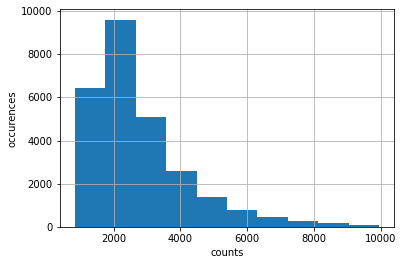

In [6]:
plt.figure()
spleen2_library_size.hist() ## plot histogram of library sizes
plt.xlabel('counts')
plt.ylabel('occurences')


In [7]:
spleen2_mean=pandas.DataFrame(spleen2.X).mean(axis=0) ## calculate mean read count of each gene


In [8]:
spleen2_variance=pandas.DataFrame(spleen2.X).var() ## calculate the variance of each gene


Text(0, 0.5, 'variance')

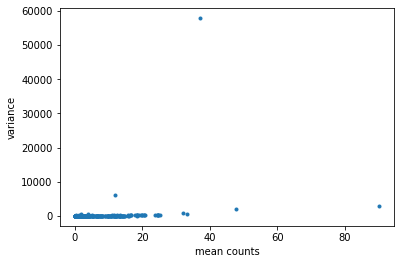

In [9]:
plt.figure()
plt.scatter(spleen2_mean, spleen2_variance, marker='.') ## plot mean variance relationship for genes
plt.xlabel('mean counts')
plt.ylabel('variance')


In [10]:
print(spleen2_variance.nlargest(2)) ## print the 2 genes showing the largest variance


3134    57854.082031
7107     6049.548340
dtype: float32


In [11]:
spleen1_genes=pandas.DataFrame(spleen1.var_names) ## write gene list into a dataframe 


In [12]:
spleen1_genes.iloc[[3134, 7107]] ## obtain names of the genes that show the largest variance


,index
3134,Igkc
7107,Ighm


In [13]:
spleen2_expression=pandas.DataFrame(spleen2._X) ## write read counts into a data frame


In [14]:
spleen2_filtered=spleen2_expression.drop([spleen2_expression.columns[3134], spleen2_expression.columns[7107]], axis=1) ## drop the two genes with largest variance


In [15]:
spleen2_filtered_mean=spleen2_filtered.mean(axis=0) ## calculate mean read count of each gene after the two with highest variance were dropped


In [16]:
spleen2_filtered_variance=spleen2_filtered.var() ## calculate variance of each gene after the two with highest variance were dropped


Text(0, 0.5, 'variance')

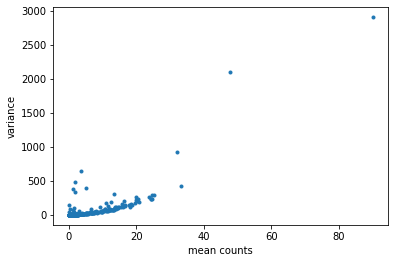

In [17]:
plt.figure()
plt.scatter(spleen2_filtered_mean, spleen2_filtered_variance, marker='.') ## plot mean variance relationship with the two genes with the highest variance dropped
plt.xlabel('mean counts')
plt.ylabel('variance')
## with the two genes that have the highest variance across all samples removed, we can see the heteroscedasticity in the mean - variance relationship

In [18]:
spleen2_nomralize_1=spleen2_expression.div(spleen2_library_size, axis='rows') ## normalize by library size


In [19]:
spleen2_cpm_1=spleen2_nomralize_1.mul(1e6) ## calculate counts per million


In [20]:
spleen2_log_1=numpy.log1p(spleen2_cpm_1+1) ## log transform with pseudo 1 added


In [21]:
spleen2_log_1_mean=spleen2_log_1.mean(axis=0) ## calculate mean of log read counts


In [22]:
spleen2_log_1_variance=spleen2_log_1.var() ## calculate variace of log read counts


Text(0, 0.5, 'variance')

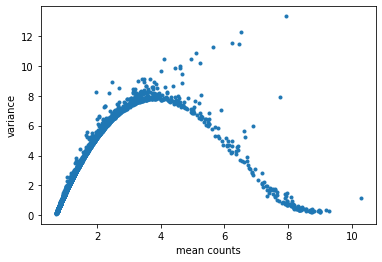

In [23]:
plt.figure()
plt.scatter(spleen2_log_1_mean, spleen2_log_1_variance, marker='.') ## mean variance relationship of log read counts
plt.xlabel('mean counts')
plt.ylabel('variance')


In [24]:
spleen1_normalized=spleen1 ## write spleen1 into spleen1_normalized - this helps to keep the original data in the work space


In [25]:
spleen1_normalized.X=spleen2_log_1 ## sets the read count for spleen1_normalized to log read counts


In [26]:
####Create new column in spleen1_normalized._obs that combines cell type and mouse age for downstream grouping

spleen1_normalized_cell_age=pandas.DataFrame(spleen1_normalized._obs).iloc[:, [0,11]]
spleen1_normalized_cell_age["cell_type_age"]=spleen1_normalized_cell_age["age"].astype(str)+spleen1_normalized_cell_age["cell_type"].astype(str)
spleen1_normalized._obs["cell_type_age"]=spleen1_normalized_cell_age["cell_type_age"]


In [27]:
spleen1_normalized._obs["cell_type_age"].head(5)
## the code in [26] produces an extra column in spleen1_normalized._obs that looks like that shown below - grouping samples according to
####celltype and age

index
AAACCTGAGAGCTTCT-1-0    oldB cell
AAACCTGAGATCGATA-1-0    oldB cell
AAACCTGAGTGTACCT-1-0    oldB cell
AAACCTGCATCCGCGA-1-0    oldT cell
AAACCTGGTAAGTTCC-1-0    oldB cell
Name: cell_type_age, dtype: object

In [28]:
####Obtain mean read counts and variance by cell type for log transformed data

grouping_key=['cell_type']
grouped=spleen1_normalized._obs.groupby(grouping_key)
out_mean_celltype=pandas.DataFrame(numpy.zeros((spleen1_normalized.shape[1], len(grouped)), dtype=numpy.float64), columns=list(grouped.groups.keys()), index=spleen1_normalized.var_names)
out_variance_celltype=pandas.DataFrame(numpy.zeros((spleen1_normalized.shape[1], len(grouped)), dtype=numpy.float64), columns=list(grouped.groups.keys()), index=spleen1_normalized.var_names)
getX = lambda x: x.X

for group, idx in grouped.indices.items():
    X=getX(spleen1_normalized[idx])
    out_mean_celltype[group]=numpy.ravel(X.mean(axis=0, dtype=numpy.float64))
    out_variance_celltype[group]=numpy.ravel(X.var(axis=0, dtype=numpy.float64))

out_mean_celltype.to_csv('/mnt/d/sc_rna_data_project_20201113/mca_spleen_filtered_mean_expression_by_celltype.csv')
out_variance_celltype.to_csv('/mnt/d/sc_rna_data_project_20201113/mca_spleen_filtered_variance_by_celltype.csv')


In [29]:
####Get top 25 rank genes for each cell type

scanpy.tl.rank_genes_groups(spleen1_normalized, 'cell_type', method='t-test')


... storing 'cell_type_age' as categorical


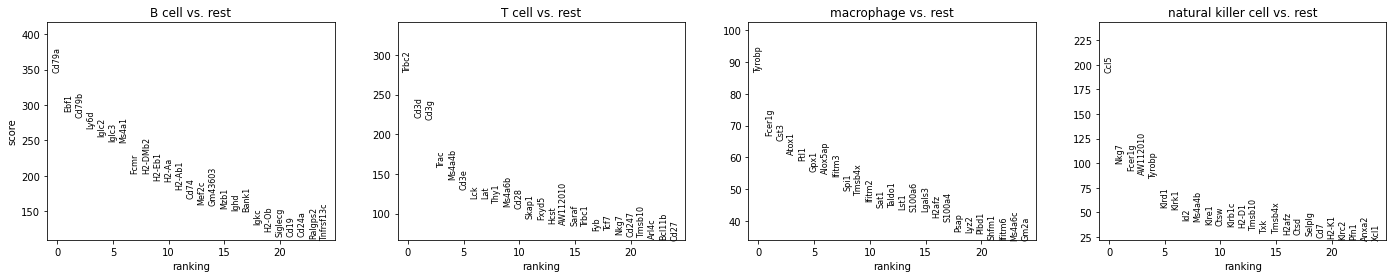

In [30]:
scanpy.pl.rank_genes_groups(spleen1_normalized, n_genes=25, sharey=False)


In [31]:
mca_spleen_filtered_top25_rank_genes_celltype=pandas.DataFrame(spleen1_normalized.uns['rank_genes_groups']['names']).head(25)


In [32]:
mca_spleen_filtered_top25_rank_genes_celltype.to_csv('/mnt/d/sc_rna_data_project_20201113/mca_spleen_filtered_top25_rank_genes_celltype.csv')


In [33]:
####Obtain mean read counts and variance by cell type and age for log transformed data

grouping_key=['cell_type_age']
grouped=spleen1_normalized._obs.groupby(grouping_key)
out_mean_celltype_age=pandas.DataFrame(numpy.zeros((spleen1_normalized.shape[1], len(grouped)), dtype=numpy.float64), columns=list(grouped.groups.keys()), index=spleen1_normalized.var_names)
out_variance_celltype_age=pandas.DataFrame(numpy.zeros((spleen1_normalized.shape[1], len(grouped)), dtype=numpy.float64), columns=list(grouped.groups.keys()), index=spleen1_normalized.var_names)
getX = lambda x: x.X

for group, idx in grouped.indices.items():
    X=getX(spleen1_normalized[idx])
    out_mean_celltype_age[group]=numpy.ravel(X.mean(axis=0, dtype=numpy.float64))
    out_variance_celltype_age[group]=numpy.ravel(X.var(axis=0, dtype=numpy.float64))

out_mean_celltype_age.to_csv('/mnt/d/sc_rna_data_project_20201113/mca_spleen_filtered_mean_expression_by_celltype_age.csv')
out_variance_celltype_age.to_csv('/mnt/d/sc_rna_data_project_20201113/mca_spleen_filtered_variance_by_celltype_age.csv')


In [34]:
####Get top 25 rank genes for each cell type

scanpy.tl.rank_genes_groups(spleen1_normalized, 'cell_type_age', method='t-test')


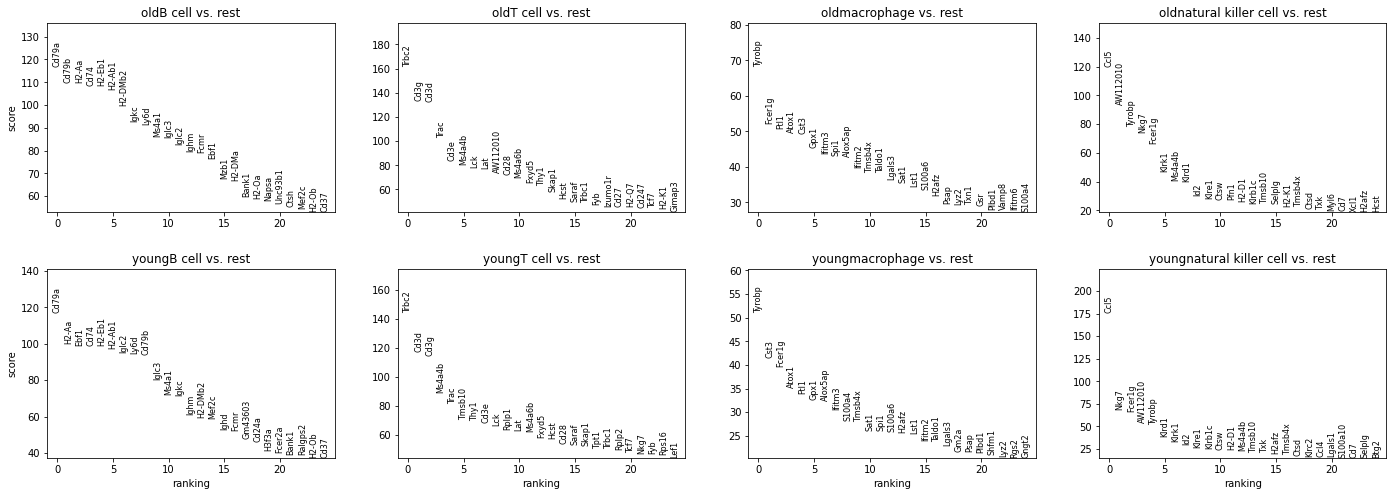

In [35]:
scanpy.pl.rank_genes_groups(spleen1_normalized, n_genes=25, sharey=False)


In [36]:
mca_spleen_filtered_top25_rank_genes_celltype_age=pandas.DataFrame(spleen1_normalized.uns['rank_genes_groups']['names']).head(25)


In [37]:
mca_spleen_filtered_top25_rank_genes_celltype_age.to_csv('/mnt/d/sc_rna_data_project_20201113/mca_spleen_filtered_top25_rank_genes_celltype_age.csv')
